In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from asgn1.cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import DataUtils as du
X_train, y_train, P_train, X_val, y_val, P_val, X_test, y_test, P_test = du.loadData()

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (18927, 32, 32, 3)
Train labels shape:  (18927,)
Validation data shape:  (5375, 32, 32, 3)
Validation labels shape:  (5375,)
Test data shape:  (2682, 32, 32, 3)
Test labels shape:  (2682,)


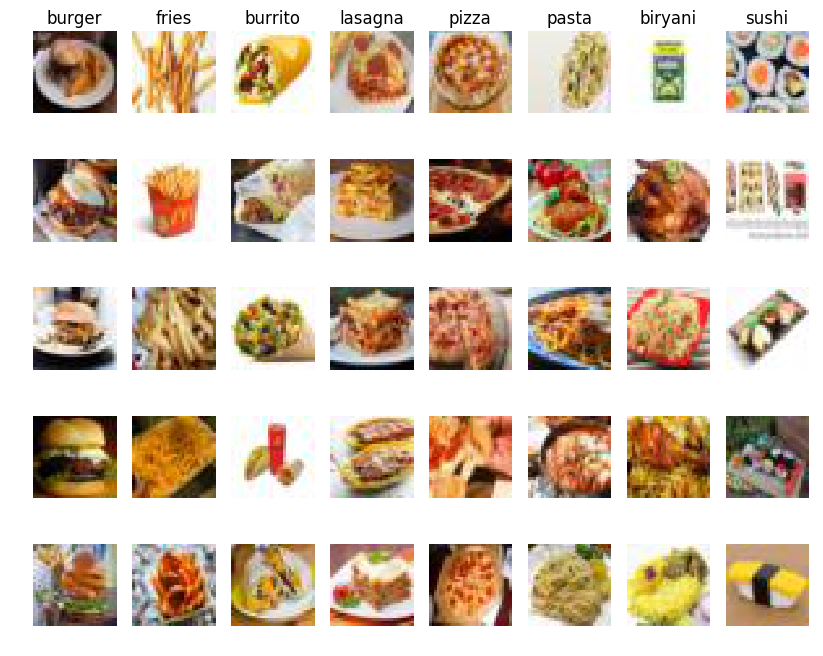

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['burger', 'fries', 'burrito', 'lasagna', 'pizza', 'pasta', 'biryani', 'sushi']
num_classes = len(classes)
samples_per_class = 5
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)

#plt.savefig('assets/data_vis_2.png')
plt.show()

In [4]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)

Training data shape:  (18927, 3072)
Validation data shape:  (5375, 3072)
Test data shape:  (2682, 3072)


[ 152.49960374  139.56469594  127.47429598  153.88349976  140.68299255
  128.29439425  155.10249908  141.58461457  128.81085222  156.33417869]


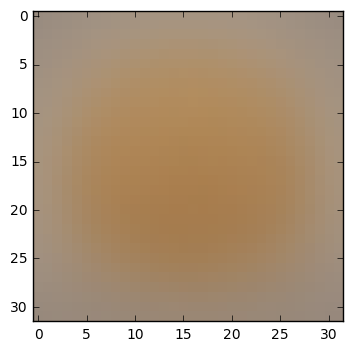

In [5]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [6]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

In [7]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape)

(18927, 3073) (5375, 3073) (2682, 3073)


In [8]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from asgn1.cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 20) * 0.0001
loss, grad = softmax_loss_naive(W, X_test, y_test, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.05).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.05)))

loss: 3.046343
sanity check: 2.995732


In [9]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from asgn1.cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
#learning_rates = [1e-7, 5e-7]
#regularization_strengths = [2.5e4, 5e4]

learning_rates = [1e-6]
regularization_strengths = [1e1, 1e2, 1e3, 1e4, 1e5]

for _l in learning_rates:
    for _r in regularization_strengths:
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, learning_rate=_l, reg=_r,
                      num_iters=1500, verbose=False)
                
        y_train_pred = softmax.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        
        y_val_pred = softmax.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)

        results[(_l, _r)] = (train_accuracy, val_accuracy)
        if (val_accuracy > best_val):
            best_val = val_accuracy
            best_softmax = softmax
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-06 reg 1.000000e+01 train accuracy: 0.178845 val accuracy: 0.144930
lr 1.000000e-06 reg 1.000000e+02 train accuracy: 0.197020 val accuracy: 0.165023
lr 1.000000e-06 reg 1.000000e+03 train accuracy: 0.235959 val accuracy: 0.200372
lr 1.000000e-06 reg 1.000000e+04 train accuracy: 0.171343 val accuracy: 0.165023
lr 1.000000e-06 reg 1.000000e+05 train accuracy: 0.119036 val accuracy: 0.119256
best validation accuracy achieved during cross-validation: 0.200372


In [10]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.193139


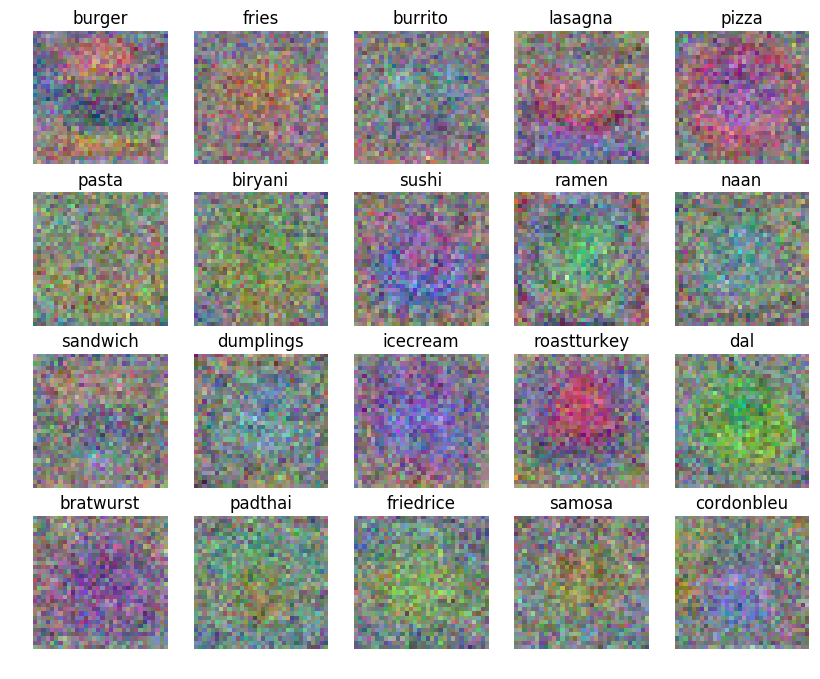

In [12]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 20)
w_min, w_max = np.min(w), np.max(w)
classes = ["burger","fries","burrito","lasagna","pizza","pasta","biryani","sushi","ramen","naan","sandwich","dumplings","icecream",
"roastturkey","dal","bratwurst","padthai","friedrice","samosa","cordonbleu"]

for i in range(20):
    plt.subplot(4, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])
    
#plt.savefig('assets/data_vis_svm_learned_weights.png')
plt.show()